In [1]:
import cv2
from ultralytics import YOLO
import requests
import json
from PIL import Image # For displaying images in Notebook
import numpy as np
import os
import time # For potential delays if needed

# --- Configuration ---
# CHOOSE OPERATION MODE: "file" or "camera"
OPERATION_MODE = "file"  # <<<< CHANGE THIS TO "camera" TO USE CAMERA MODE
# OPERATION_MODE = "camera"

# YOLO Configuration
YOLO_MODEL_NAME = 'resource/yolov8n.pt'

# Ollama / DeepSeek Configuration
OLLAMA_API_URL = "http://localhost:11434/api/generate"
DEEPSEEK_MODEL_NAME = "deepseek-r1:8b" # 默认使用 "deepseek-llm"，请根据 `ollama list` 的结果修改

# Input Image Path (used only if OPERATION_MODE is "file")
INPUT_IMAGE_PATH = "resource/bus.jpg" # 例如: "test_images/bus.jpg"

# Camera Configuration (used only if OPERATION_MODE is "camera")
CAMERA_INDEX = 0 # 0 for default camera, change if you have multiple cameras

# --- Sanity Checks ---
print("Libraries imported.")
print(f"Selected Operation Mode: {OPERATION_MODE}")
print(f"Using YOLO model: {YOLO_MODEL_NAME}")
print(f"Ollama API URL: {OLLAMA_API_URL}")
print(f"Attempting to use DeepSeek model: {DEEPSEEK_MODEL_NAME}")

if DEEPSEEK_MODEL_NAME == "your-deepseek-model-name": # Default placeholder check
    print("\n⚠️ WARNING: 'DEEPSEEK_MODEL_NAME' is set to a placeholder. Please update it with your actual model name from Ollama (run `ollama list`).")

if OPERATION_MODE == "file":
    if not os.path.exists(INPUT_IMAGE_PATH) and INPUT_IMAGE_PATH != "path/to/your/image.jpg":
        print(f"\n⚠️ WARNING: Input image not found at '{INPUT_IMAGE_PATH}'. Please check the path.")
    elif INPUT_IMAGE_PATH == "path/to/your/image.jpg":
         print(f"\n⚠️ WARNING: Please update 'INPUT_IMAGE_PATH' to your desired image for file mode.")
elif OPERATION_MODE not in ["file", "camera"]:
    print(f"\n⚠️ ERROR: Invalid 'OPERATION_MODE' ('{OPERATION_MODE}'). Choose 'file' or 'camera'.")


# Load YOLO Model (common for both modes)
try:
    yolo_model = YOLO(YOLO_MODEL_NAME)
    print(f"YOLO model '{YOLO_MODEL_NAME}' loaded successfully.")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    yolo_model = None



Libraries imported.
Selected Operation Mode: file
Using YOLO model: resource/yolov8n.pt
Ollama API URL: http://localhost:11434/api/generate
Attempting to use DeepSeek model: deepseek-r1:8b
YOLO model 'resource/yolov8n.pt' loaded successfully.


In [2]:
def detect_objects_yolo(image_np, model):
    """
    Performs object detection using YOLO model.
    Args:
        image_np (numpy.ndarray): Image in NumPy array format (BGR).
        model (ultralytics.YOLO): Loaded YOLO model.
    Returns:
        tuple: (list of detections, annotated_image_np)
               Each detection is a dict: {'class_name': str, 'confidence': float, 'bbox': [x1, y1, x2, y2]}
               annotated_image_np is the image with detections drawn on it.
    """
    if model is None:
        print("YOLO model not loaded. Skipping detection.")
        return [], image_np

    detections_list = []
    try:
        results = model(image_np, verbose=False)  # verbose=False to reduce console output

        # Assuming results[0] contains detections for the first image
        if results and results[0]:
            annotated_image = results[0].plot() # This returns a BGR NumPy array
            boxes = results[0].boxes
            names = results[0].names # Class names

            for box in boxes:
                class_id = int(box.cls[0])
                class_name = names[class_id]
                confidence = float(box.conf[0])
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                detections_list.append({
                    'class_name': class_name,
                    'confidence': confidence,
                    'bbox': [x1, y1, x2, y2]
                })
        else:
            annotated_image = image_np # Return original if no results
            
    except Exception as e:
        print(f"Error during YOLO detection: {e}")
        return [], image_np # Return original image in case of error

    return detections_list, annotated_image

print("YOLO detection helper function defined.")


YOLO detection helper function defined.


In [3]:
# Cell 3: Helper Function - Format Detections as JSON for LLM (Step C)
def format_detections_as_json_for_llm(detections):
    """
    Converts YOLO detections (list of dicts) into a JSON string for an LLM.
    Args:
        detections (list): List of detection dicts from detect_objects_yolo.
                           Each dict: {'class_name': str, 'confidence': float, 'bbox': [x1, y1, x2, y2]}
    Returns:
        str: A JSON string representation of the detections, or a message if no detections.
    """
    if not detections:
        return "No objects were detected in the image."
    
    # Convert the list of detection dictionaries to a JSON string
    # indent=2 makes the JSON string more readable if printed or logged.
    return json.dumps(detections, indent=2)

print("Detection formatting (JSON) helper function defined.")


Detection formatting (JSON) helper function defined.


In [4]:
def generate_text_with_deepseek(prompt_text, model_name=DEEPSEEK_MODEL_NAME, ollama_url=OLLAMA_API_URL):
    """
    Sends a prompt to a DeepSeek model via Ollama and returns the response.
    """
    if model_name == "your-deepseek-model-name":
        return "Error: DeepSeek model name not configured. Please update 'DEEPSEEK_MODEL_NAME' in Cell 1."

    payload = {
        "model": model_name,
        "prompt": prompt_text,
        "stream": False  # Get the full response at once
    }
    headers = {"Content-Type": "application/json"}

    print(f"\nSending prompt to DeepSeek model '{model_name}'...")
    try:
        response = requests.post(ollama_url, data=json.dumps(payload), headers=headers, timeout=180) # Increased timeout
        response.raise_for_status()
        response_data = response.json()
        if "response" in response_data:
            return response_data["response"].strip()
        else:
            return f"Error: 'response' key not found in Ollama API return. Full response: {response_data}"
    except requests.exceptions.ConnectionError:
        return f"Error: Could not connect to Ollama at {ollama_url}. Is Ollama running?"
    except requests.exceptions.Timeout:
        return f"Error: Request to Ollama timed out. The model might be taking too long or the service is unresponsive."
    except requests.exceptions.HTTPError as e:
        return f"Error: HTTP error from Ollama: {e}. Response: {e.response.text if e.response else 'No response body'}"
    except json.JSONDecodeError:
        return f"Error: Could not decode JSON response from Ollama. Response text: {response.text}"
    except Exception as e:
        return f"Error: An unexpected error occurred while querying DeepSeek: {e}"

print("DeepSeek text generation helper function defined.")


DeepSeek text generation helper function defined.


In [5]:
# Cell 5: Core Processing Function

def process_image_and_describe(image_bgr, yolo_model, deepseek_model_name, ollama_api_url):
    """
    Processes a single image frame: performs YOLO detection, formats results,
    and generates a natural language description using DeepSeek via Ollama.

    Args:
        image_bgr (numpy.ndarray): The input image frame in BGR format.
        yolo_model (ultralytics.YOLO): The loaded YOLO model.
        deepseek_model_name (str): The name of the DeepSeek model in Ollama.
        ollama_api_url (str): The URL for the Ollama generate API.

    Returns:
        tuple: (natural_language_description, annotated_image_bgr)
               Returns (None, original_image_bgr) if processing fails at any step.
    """
    if image_bgr is None:
        print("Error: Input image to process_image_and_describe is None.")
        return "Error: Input image is invalid.", None

    if yolo_model is None:
        print("Error: YOLO model is not loaded.")
        return "Error: YOLO model is not available.", image_bgr.copy()

    if not deepseek_model_name or deepseek_model_name == "your-deepseek-model-name":
         print("Error: DeepSeek model name is not configured.")
         return "Error: DeepSeek model name is not configured.", image_bgr.copy()

    try:
        image_height, image_width = image_bgr.shape[:2]
        # print(f"Processing frame dimensions: Width={image_width}, Height={image_height}") # Optional: verbose

        # --- Step B: YOLO Object Detection ---
        # print("  Running YOLO Object Detection...") # Optional: verbose
        detections, annotated_image_bgr = detect_objects_yolo(image_bgr.copy(), yolo_model)

        # --- Step C: Formatting Detections as JSON for LLM ---
        # print("  Formatting Detections as JSON...") # Optional: verbose
        detections_json_string = format_detections_as_json_for_llm(detections)
        # print(f"  Detections JSON:\n{detections_json_string}") # Optional: verbose

        # --- Step D: DeepSeek Text Generation ---
        # print("  Generating Text with DeepSeek...") # Optional: verbose

        if detections_json_string == "No objects were detected in the image.":
            prompt_for_llm = f"""
You are an AI assistant that describes images.
The object detection process found no specific objects in an image that is {image_width} pixels wide and {image_height} pixels high.
Please provide a very brief, general description acknowledging this, for example, "The image appears to have no distinct objects detected."
"""
        else:
            prompt_for_llm = f"""
You are an AI assistant that describes images based on a list of detected objects provided in JSON format.
The image dimensions are {image_width} pixels wide and {image_height} pixels high.
The following is a JSON list of objects detected in the image. Each object has:
- 'class_name': The identified type of the object.
- 'confidence': The model's confidence in this detection (a value between 0.0 and 1.0).
- 'bbox': A list of four integers [x_center , y_center, width, height]
Detected objects data:
{detections_json_string}
Based on this structured data, please generate a concise and natural language description of the scene. Try to infer relationships between objects and their general locations (e.g., "left side", "center", "behind another object") rather than just listing the raw bounding box coordinates. Focus on creating a human-like, coherent description of what the image likely contains.
"""
        # print(f"  Prompt being sent to DeepSeek:\n{prompt_for_llm}") # Optional: verbose

        natural_language_description = generate_text_with_deepseek(prompt_for_llm, deepseek_model_name, ollama_api_url)

        # --- Step E: Output Natural Language Description (Handled by caller) ---
        # The description is returned, the caller will print it.

        return natural_language_description, annotated_image_bgr

    except Exception as e:
        print(f"An error occurred during image processing: {e}")
        traceback.print_exc()
        return f"Error processing image: {e}", image_bgr.copy() # Return original image on error

print("Core processing function 'process_image_and_describe' defined.")


Core processing function 'process_image_and_describe' defined.


--- Running in FILE mode for image: resource/bus.jpg ---

--- Original Image ---


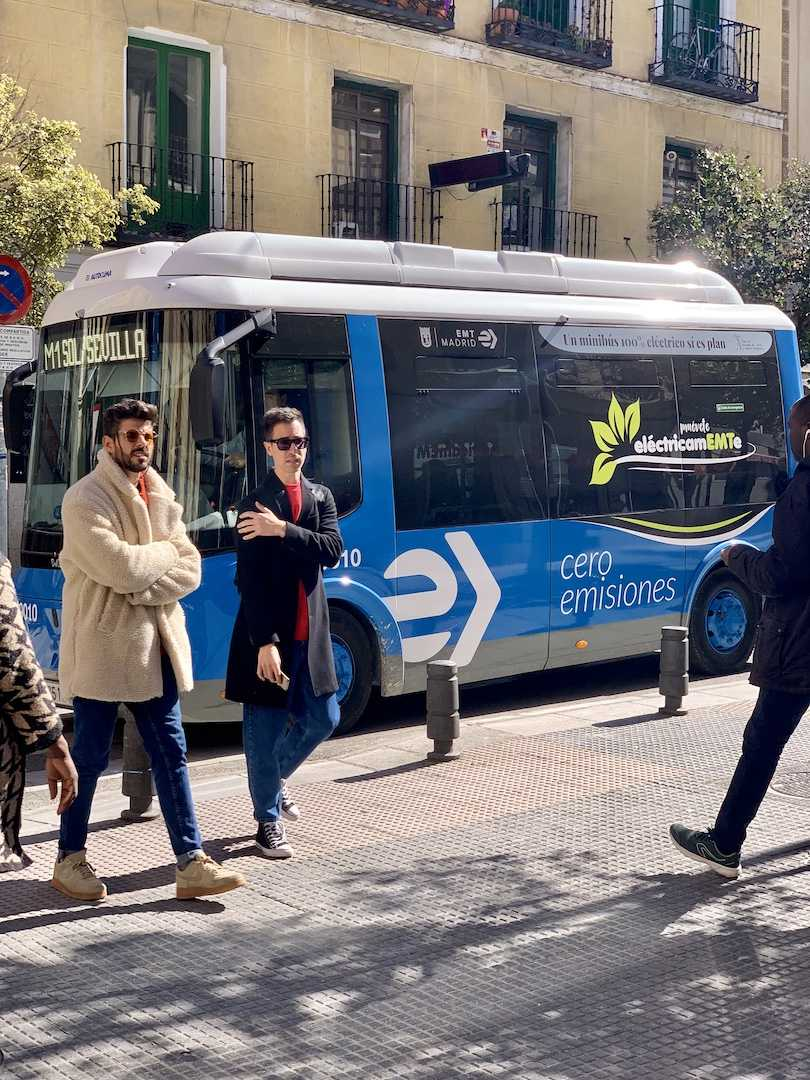


--- Processing Image ---

Sending prompt to DeepSeek model 'deepseek-r1:8b'...

--- Annotated Image (YOLO Detections) ---


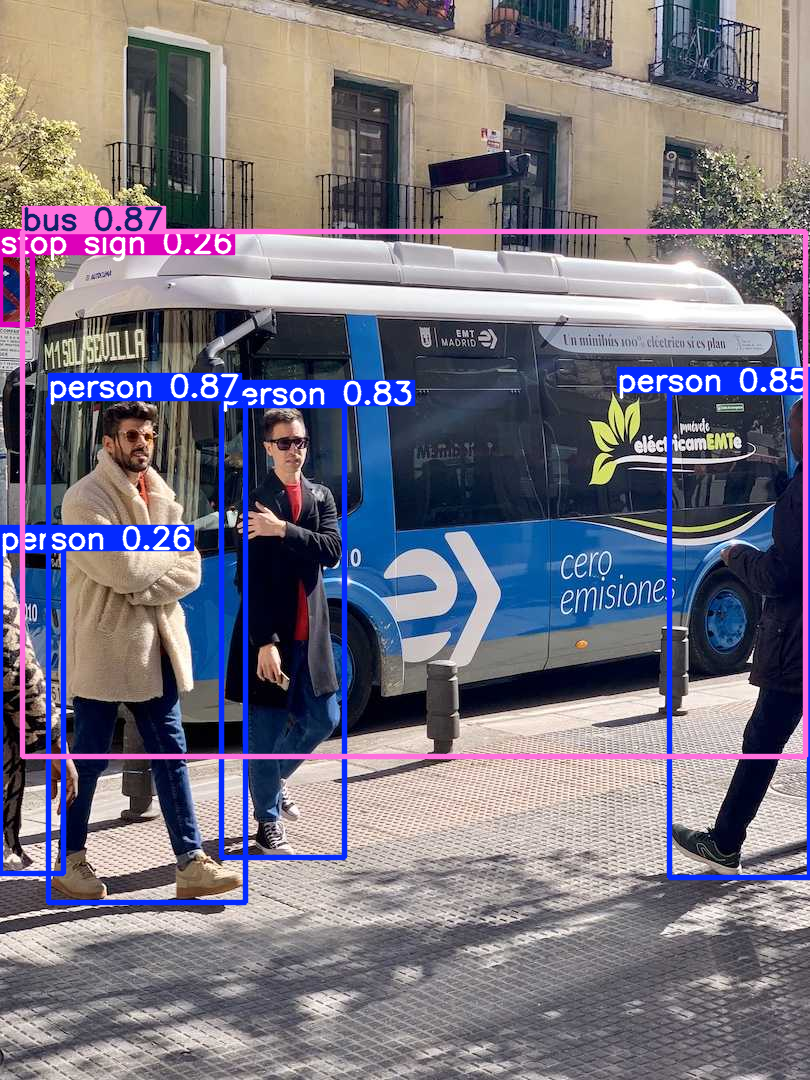


--- Natural Language Description ---
<think>
Okay, let's start by understanding the user's query. They want me to generate a concise and natural language description of an image based on JSON data containing detected objects. The dimensions are given as 810x1080 pixels.

First, I need to parse all the objects in the JSON. There are five people and one stop sign. Each object has bounding box coordinates [x_center, y_center, width, height]. Since the image is vertical (assuming height is more significant), higher y values mean objects lower down.

Looking at the first person's bbox: x=48, y=398. That's near the top since y_center is 398 and the image height starts from 0 to about 1080. The second person has a bbox starting at x=221, same y-center as the first? Wait no, let me check each one.

The bus bbox: [22, 231, 805, 756]. That's a very large bounding box with width almost the entire image (810 pixels). So this bus is probably in the middle or front. The x_center is low (22), which 

In [6]:
# Ensure Cell 1, 2, 3, 4, and 5 have been run to define variables and functions.

# --- Preliminary Checks ---
if yolo_model is None:
    print("Skipping workflow: YOLO model failed to load. Please check Cell 1.")
elif DEEPSEEK_MODEL_NAME == "your-deepseek-model-name" or not DEEPSEEK_MODEL_NAME:
    print("Skipping workflow: DeepSeek model name not configured correctly. Please check Cell 1.")
elif OPERATION_MODE not in ["file", "camera"]:
    print(f"Skipping workflow: Invalid 'OPERATION_MODE' ('{OPERATION_MODE}') in Cell 1. Choose 'file' or 'camera'.")
else:
    # --- FILE MODE ---
    if OPERATION_MODE == "file":
        print(f"--- Running in FILE mode for image: {INPUT_IMAGE_PATH} ---")
        if not os.path.exists(INPUT_IMAGE_PATH) or INPUT_IMAGE_PATH == "path/to/your/image.jpg":
            print(f"Skipping file mode: Input image path '{INPUT_IMAGE_PATH}' is invalid or not set. Please check Cell 1.")
        else:
            try:
                input_image_bgr = cv2.imread(INPUT_IMAGE_PATH)
                if input_image_bgr is None:
                    raise FileNotFoundError(f"Could not read image at {INPUT_IMAGE_PATH}")

                print("\n--- Original Image ---")
                input_image_rgb = cv2.cvtColor(input_image_bgr, cv2.COLOR_BGR2RGB)
                display(Image.fromarray(input_image_rgb))

                # Call the shared processing function
                print("\n--- Processing Image ---")
                description, annotated_image_bgr = process_image_and_describe(
                    input_image_bgr, yolo_model, DEEPSEEK_MODEL_NAME, OLLAMA_API_URL
                )

                # --- Output Results ---
                print("\n--- Annotated Image (YOLO Detections) ---")
                if annotated_image_bgr is not None:
                    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
                    display(Image.fromarray(annotated_image_rgb))
                else:
                    print("Annotated image is not available.")

                print("\n--- Natural Language Description ---")
                print(description)

            except FileNotFoundError as e_file:
                print(f"Error in file mode: {e_file}")
            except Exception as e_file_main:
                print(f"An unexpected error occurred in file mode: {e_file_main}")
                traceback.print_exc()

    # --- CAMERA MODE ---
    elif OPERATION_MODE == "camera":
        print(f"--- Running in CAMERA mode (Camera Index: {CAMERA_INDEX}) ---")
        cap = cv2.VideoCapture(CAMERA_INDEX)
        if not cap.isOpened():
            print(f"Error: Could not open camera with index {CAMERA_INDEX}. Please check if the camera is connected and not in use.")
        else:
            print("Camera opened successfully.")
            print("Instructions: Focus the OpenCV window. Press 'c' to capture and process the current frame. Press 'q' to quit.")

            window_name_annotated = "Annotated Frame (Press 'c' for next, 'q' to quit)"
            cv2.namedWindow(window_name_annotated, cv2.WINDOW_AUTOSIZE)

            try:
                while True:
                    print("\nWaiting for your command... (Focus OpenCV window: Press 'c' to capture, 'q' to quit)")

                    key = cv2.waitKey(0) & 0xFF # Wait indefinitely for a key press

                    if key == ord('q'):
                        print("Quit command received. Exiting camera mode.")
                        break
                    elif key == ord('c'):
                        print("Capture command received.")
                        ret, frame_bgr = cap.read()
                        if not ret:
                            print("Error: Could not read frame from camera. Exiting.")
                            break

                        print(f"\n--- Processing new frame from camera ---")

                        # Call the shared processing function
                        description, annotated_frame_bgr = process_image_and_describe(
                            frame_bgr, yolo_model, DEEPSEEK_MODEL_NAME, OLLAMA_API_URL
                        )

                        # --- Output Results ---
                        print("\n--- Natural Language Description ---")
                        print(description)

                        print("\n--- Annotated Frame (YOLO Detections) ---")
                        if annotated_frame_bgr is not None:
                            cv2.imshow(window_name_annotated, annotated_frame_bgr)
                        else:
                             # If annotation failed, show the original captured frame
                            cv2.imshow(window_name_annotated, frame_bgr)
                            print("Annotated frame is not available, showing original captured frame.")
                        cv2.waitKey(1) # Allow window to update

                        print("-" * 70) # Separator for next iteration

                    else:
                        # Optional: Handle other key presses if needed
                        print(f"Key '{chr(key)}' pressed. Press 'c' to capture or 'q' to quit.")
                        pass

            except KeyboardInterrupt:
                print("Camera mode interrupted by user (Ctrl+C).")
            except Exception as e_cam_main:
                print(f"An unexpected error occurred in camera mode: {e_cam_main}")
                traceback.print_exc()
            finally:
                if 'cap' in locals() and cap.isOpened():
                    cap.release()
                    print("Camera released.")
                cv2.destroyAllWindows()
                print("OpenCV windows closed.")

